In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np

In [3]:
df_raw = pd.read_csv('coords_filtered.csv', header=None, sep=";")
df_raw.columns = ["code", "Name", "Latitude", "Longitude", "desc"]

In [36]:
# randomly subsample 1000 indices
df_sampled = df_raw.sample(n=len(df_raw), random_state=42, replace=True)
df = df_sampled.copy()

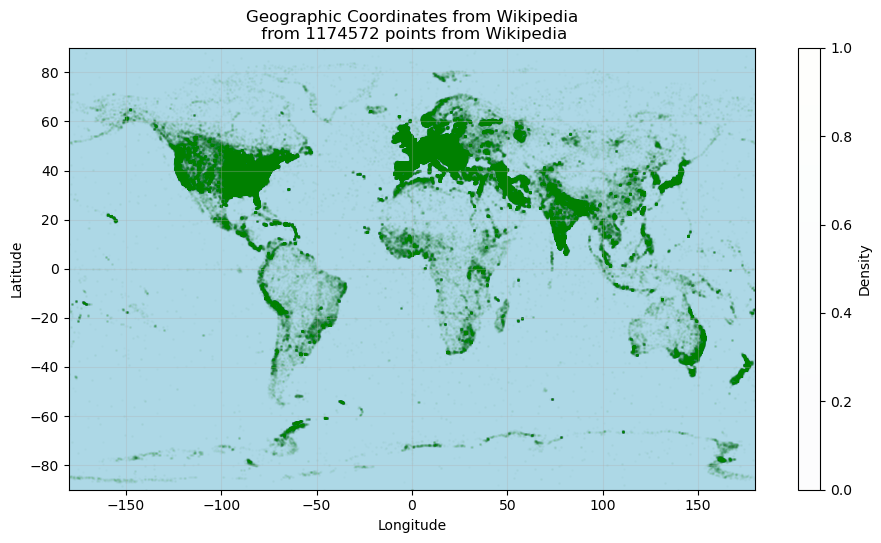

In [40]:
# Full version with labels and formatting
import pandas as pd
import matplotlib.pyplot as plt


# Create 947x553 pixel plot
plt.figure(figsize=(9.47, 5.53), dpi=100)

# Background blue
plt.gca().set_facecolor('lightblue')

# Plot points
plt.scatter(df['Longitude'], df['Latitude'], c='green', s=1, alpha=0.01)

# Format plot
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'Geographic Coordinates from Wikipedia\n from {len(df_raw)} points from Wikipedia')
plt.grid(True, alpha=0.3)
plt.tight_layout()

# add colorbar
plt.colorbar(label='Density')

# y-ticks every 20, from 80 to -80
plt.yticks(np.arange(-80, 81, 20))
# Limit at 90
plt.ylim(-90, 90)

# limit at 160
plt.xlim(-180, 180)

# Save to figure
plt.savefig('coords_sampled.png', dpi=300, bbox_inches='tight')